# Praca domowa nr 2 (SHAP)
Autor: Paulina Tomaszewska

## Pakiety

In [20]:
import numpy as np
import pandas as pd
import sklearn
from sklearn.preprocessing import LabelEncoder

## Wczytanie danych

In [21]:
data=pd.read_csv("mushrooms.csv")
data.head()

class cap-shape cap-surface cap-color bruises odor gill-attachment  \
0     p         x           s         n       t    p               f   
1     e         x           s         y       t    a               f   
2     e         b           s         w       t    l               f   
3     p         x           y         w       t    p               f   
4     e         x           s         g       f    n               f   

  gill-spacing gill-size gill-color  ... stalk-surface-below-ring  \
0            c         n          k  ...                        s   
1            c         b          k  ...                        s   
2            c         b          n  ...                        s   
3            c         n          n  ...                        s   
4            w         b          k  ...                        s   

  stalk-color-above-ring stalk-color-below-ring veil-type veil-color  \
0                      w                      w         p          w   
1                      w                      w         p          w   
2                      w                      w         p          w   
3                      w                      w         p          w   
4                      w                      w         p          w   

  ring-number ring-type spore-print-color population habitat  
0           o         p                 k          s       u  
1           o         p                 n          n       g  
2           o         p                 n          n       m  
3           o         p                 k          s       u  
4           o         e                 n          a       g  

[5 rows x 23 columns]

## Inżynieria cech

W poprzedniej pracy domowej wykazano, że dla zbioru danych mushroom zastosowanie target encoding skutkuje niskim wynikiem accuracy. Wynik bliski 100% uzyskano stosując one-hot encoding, która jednak znacząco zwiększa wymiarowość danych. W metodzie SHAP wyliczana jest kontrybucja wszystkich zmiennych, przez co analiza w przypadku dużego większenia liczby kolumn poprzez metodę one-hot jest problematyczna. W ramach dyskusji podczas laboratoriów dowiedziałam się, że zastosowanie metody label encoder (tj. przypisanie kategoriom wartości całkowitych), mimo iż niepoprawne pod względem metodologicznym, prowadzi do wysokiej jakości predycji. Z uwagi na to, że metoda one-hot encoding i label encoding prowadzą do podobnych wartości accuracy, jednak druga z nich nie powoduje zwiększonej liczby zmiennych objaśniających, zdecydowano się na drugą metodę. 

In [22]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y=le.fit_transform(data['class'])
data.drop('class', axis=1, inplace=True)

In [23]:
for col in data.columns:
    data[col]=le.fit_transform(data[col])

In [24]:
data.head(5)

cap-shape  cap-surface  cap-color  bruises  odor  gill-attachment  \
0          5            2          4        1     6                1   
1          5            2          9        1     0                1   
2          0            2          8        1     3                1   
3          5            3          8        1     6                1   
4          5            2          3        0     5                1   

   gill-spacing  gill-size  gill-color  stalk-shape  ...  \
0             0          1           4            0  ...   
1             0          0           4            0  ...   
2             0          0           5            0  ...   
3             0          1           5            0  ...   
4             1          0           4            1  ...   

   stalk-surface-below-ring  stalk-color-above-ring  stalk-color-below-ring  \
0                         2                       7                       7   
1                         2                       7                       7   
2                         2                       7                       7   
3                         2                       7                       7   
4                         2                       7                       7   

   veil-type  veil-color  ring-number  ring-type  spore-print-color  \
0          0           2            1          4                  2   
1          0           2            1          4                  3   
2          0           2            1          4                  3   
3          0           2            1          4                  2   
4          0           2            1          0                  3   

   population  habitat  
0           3        5  
1           2        1  
2           2        3  
3           3        5  
4           0        1  

[5 rows x 22 columns]

In [25]:
from sklearn.model_selection import train_test_split
seed = 70
test_size = 0.2
x_train, x_test, y_train, y_test = train_test_split(data, y, test_size=test_size, random_state=seed)

# Klasyfikatory oparte na drzewach

- RandomForest
- xgboost
- Lightgbm

In [26]:
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
import lightgbm as lgb

def classifier(model):
    model=model.fit(x_train, y_train)
    accuracy=accuracy_score(model.predict(x_test),y_test)
    return accuracy*100, model

In [27]:
acc, model_rf =classifier(RandomForestClassifier(max_depth=6, random_state=8))
print("Accuracy RandomForest: %.2f%%" % (acc))

Accuracy RandomForest: 99.51%


In [28]:
acc, model_xgb=classifier(XGBClassifier(objective ='binary:logistic'))
print("Accuracy XGBoost: %.2f%%" % (acc))

Accuracy XGBoost: 100.00%


In [29]:
import lightgbm as lgb
# create dataset for lightgbm
d_train = lgb.Dataset(x_train, label=y_train)
d_test = lgb.Dataset(x_test, label=y_test)
#Train the model
params = {
    "max_bin": 512,
    "learning_rate": 0.005,
    "boosting_type": "gbdt",
    "objective": "binary",
    "metric": "auc",
    "num_leaves": 10,
    "verbose": -1,
    "min_data": 100,
    "boost_from_average": True
}

model_lightgbm = lgb.train(params,d_train, 10000, valid_sets=[d_test], early_stopping_rounds=50, verbose_eval=1000)

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[228]	valid_0's auc: 0.999398


## SHAP

In [30]:
import shap
import xgboost

def shap_decomposition(model, tree_based, index):
# load JS visualization code to notebook
  shap.initjs()
  if tree_based==True:
    explainer = shap.TreeExplainer(model, model_output='probability', data=shap.sample(x_test,100))
  else:
    f = lambda x: model.predict_proba(x)[:,1]
    explainer=shap.KernelExplainer(model.predict_proba, shap.sample(x_test, 100))
  shap_values = explainer.shap_values(x_test.iloc[index,:])
  return explainer, shap_values

def shap_extreme(shap_values, index_needed=True):
  if index_needed:
    data=shap_values[1]
  else:
    data=shap_values
  display(pd.DataFrame(data=data, index=x_test.columns).sort_values(by=0, ascending=False).head(5).rename(columns={0: "top shap values"}))
  display(pd.DataFrame(data=data, index=x_test.columns).sort_values(by=0, ascending=False).tail(5).rename(columns={0: "smallest shap values"}))


### W ramach pierwszego eksperymentu postanowiono sprawdzić jak będą się różniły wartości shap dla tej samej próbki (index =2), gdy zastosuje się różne klasyfikatory jednak o zbliżonych accuracy

In [31]:
example_index=2
example_sample= x_test.iloc[example_index,:]

# Random Forest

In [32]:
model_rf.predict_proba(x_test.values[example_index,:].reshape(1,-1))

array([[0.00269624, 0.99730376]])

In [33]:
explainer, shap_values=shap_decomposition(model_rf, True, example_index)
# visualize the one prediction's explanation (use matplotlib=True to avoid Javascript)
display(shap.force_plot(explainer.expected_value[1], shap_values[1],example_sample))

shap_extreme(shap_values)

top shap values
gill-size                        0.138456
gill-color                       0.103159
ring-type                        0.049886
odor                             0.046962
stalk-surface-above-ring         0.033421

smallest shap values
stalk-shape                  0.002423
cap-shape                    0.000632
veil-type                    0.000000
veil-color                   0.000000
gill-attachment              0.000000

####  Wniosek: Wszystkie zmienne zwiększają prawdopodobieństwo, że właściwą klasą jest 1 (w największym wpływ na to miało gill-size=1, gill-color=0, ring-type=0 i odor=8). 


# XGBoost

In [34]:
model_xgb.predict_proba(x_test)[example_index]

array([9.9062920e-05, 9.9990094e-01], dtype=float32)

In [35]:
explainer, shap_values=shap_decomposition(model_xgb, True, example_index)
shap.initjs()
#plotuje p-stwo klasy 1
display(shap.force_plot(explainer.expected_value, shap_values, x_test.iloc[example_index,:]))

shap_extreme(shap_values, False)

top shap values
gill-color                0.177153
odor                      0.126979
gill-size                 0.118553
population                0.042952
spore-print-color         0.037983

smallest shap values
ring-number             -0.001067
cap-color               -0.001481
cap-shape               -0.001842
stalk-shape             -0.003695
bruises                 -0.004850

### Wniosek: Największy wpływ na zwiększenie p-stwa, że prawidłową klasą jest 1 miały zmienne gill-color, odor i gill_size. Natomiast zmienne bruises, stalk-shape i cap-shape wpływały na zmniejszenie p-stwa.

ewentualne problemy z zastosowaniem xgboost: https://evgenypogorelov.com/multiclass-xgb-shap.html

# LightGBM

In [36]:
#p-stwo klasy 1
model_lightgbm.predict(x_test)[example_index]

0.8292221783000392

In [37]:
explainer, shap_values=shap_decomposition(model_lightgbm, True,example_index)
shap.initjs()
display(shap.force_plot(explainer.expected_value, shap_values, x_train.iloc[example_index,:]))

shap_extreme(shap_values,False)

top shap values
gill-color         0.087301
odor               0.085757
population         0.060543
gill-size          0.048175
stalk-root         0.045627

smallest shap values
cap-color                             0.000000
stalk-shape                           0.000000
habitat                              -0.000174
cap-shape                            -0.000180
stalk-surface-below-ring             -0.000613

### Wniosek: Do zwiększenia p-stwa, że prawidłowa jest klasa 1, przyczyniły się głównie zmienne gill-color, odor i population. Natomiast obniżeniem p-stwa skutkowały zmienne habitat, cap-shape i stalk-surface-below-ring.

# Postanowiono eksplorować inne funkcje udostępnione przez pakiet SHAP.

In [38]:
shap.initjs()
explainer = shap.TreeExplainer(model_lightgbm, model_output='probability', data=shap.sample(x_test,100))
shap_values=explainer.shap_values(x_test)
shap.force_plot(explainer.expected_value,shap_values[:1000,:], x_test.iloc[:1000,:])

### Analiza powyższego wykresu (gdy na osi poziomej wybrana jest opcja "original sample ordering") pozwoli na szybkie znalezienie różniących się przypadków. Zaobserwowano, że dla próbki o indeksie=119 znaczące różnią się zmienne o najwyższych wartościach shap w stosunku do obserwacji o indeksie=2.

In [39]:
explainer, shap_values=shap_decomposition(model_lightgbm, True,119)
shap.initjs()
display(shap.force_plot(explainer.expected_value, shap_values, x_train.iloc[119,:]))

shap_extreme(shap_values,False)

top shap values
ring-number                    0.002300
habitat                        0.000588
gill-spacing                   0.000319
stalk-color-above-ring         0.000000
cap-color                      0.000000

smallest shap values
gill-size                     -0.029231
population                    -0.041347
spore-print-color             -0.047831
stalk-root                    -0.055323
odor                          -0.123291

W przypadku tej obserwacji największy wpływ na końcową predykcję (obniżenie p-stwa) miały zmienne: odor, stalk-root i spore-print-color. Natomiast dla poprzedniej obserwacji najważniejsze były zmienne odor, gill-color i population. Nie było w analizowanym zbiorze obserwacji dla której jedną z najważniejszych zmiennych nie byłoby odor, gill-size bądź gill-color.

Jednocześnie należy zauważyć, że dla poprzedniej obserwacji zmienna odor powodowała wzrost p-stwa, podczas gdy dla obecnie analizowanej obserwacji spowodowała jego obniżenie.

## Dalsza eksploracja możliwości pakietu shap

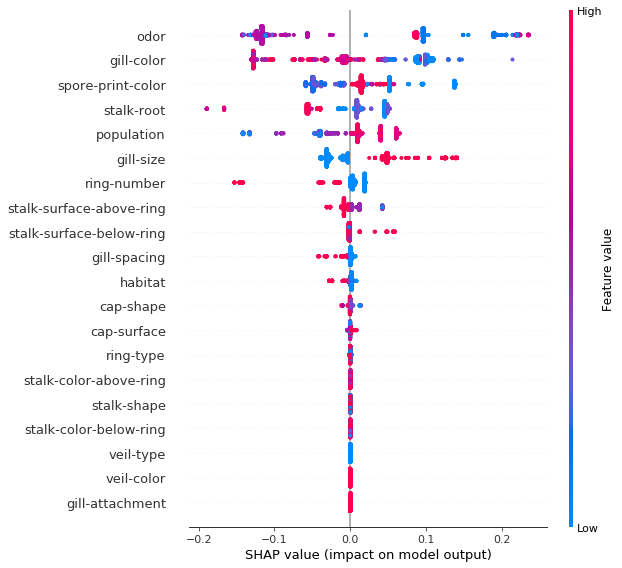

In [42]:
shap.initjs()
explainer = shap.TreeExplainer(model_lightgbm, model_output='probability', data=shap.sample(x_test,100))
shap_values=explainer.shap_values(x_test)
shap.summary_plot(shap_values, x_test)

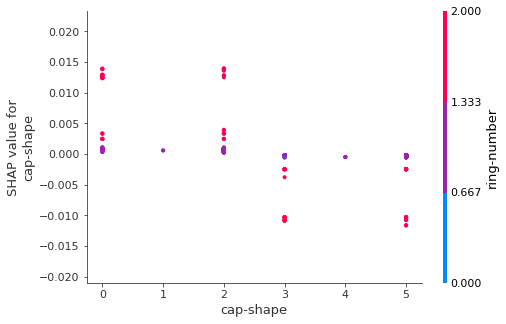

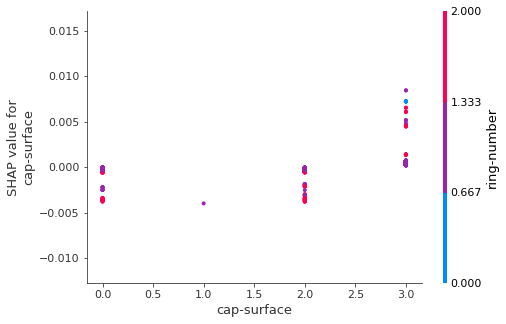

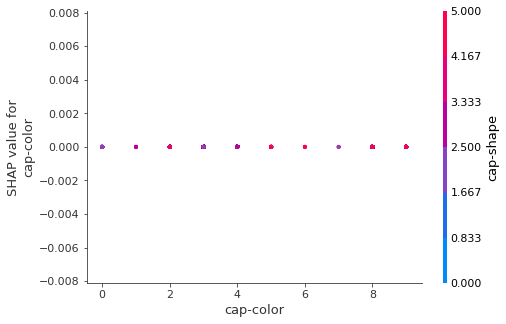

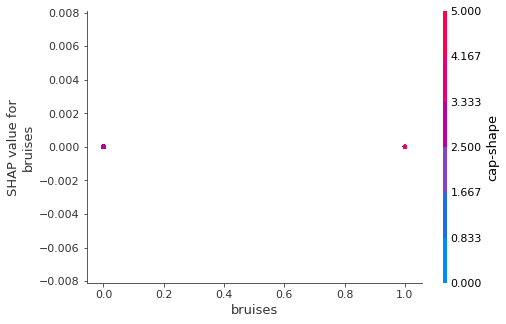

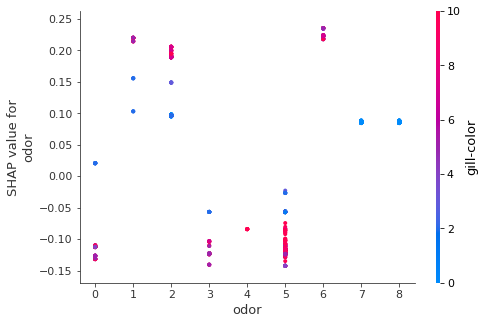

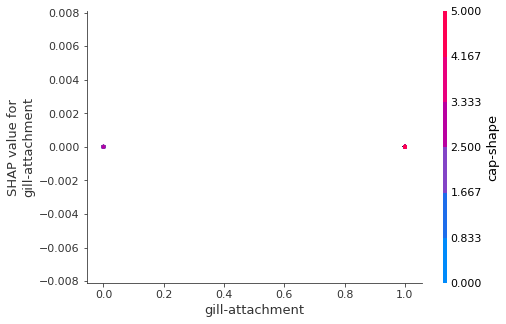

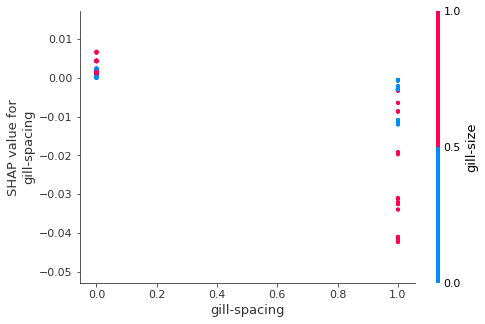

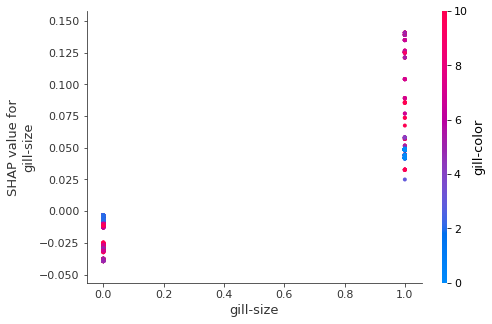

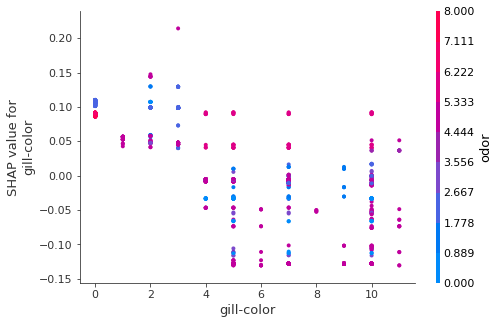

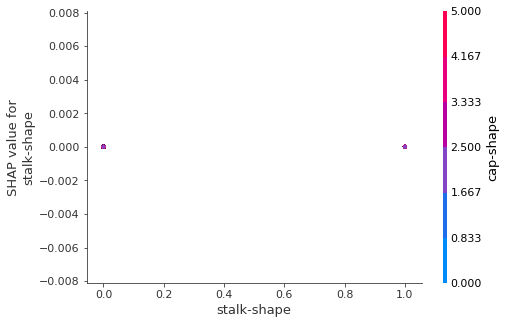

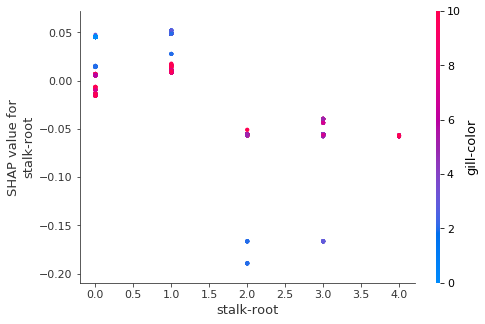

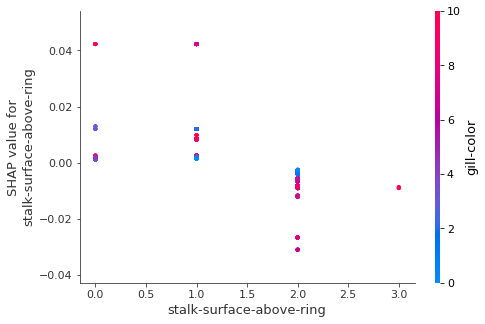

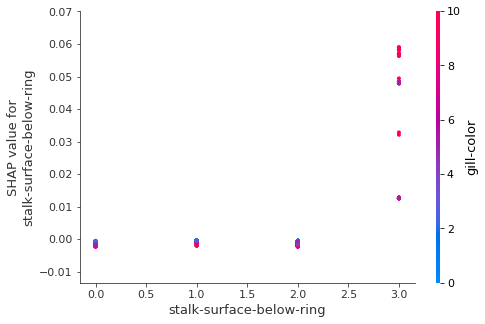

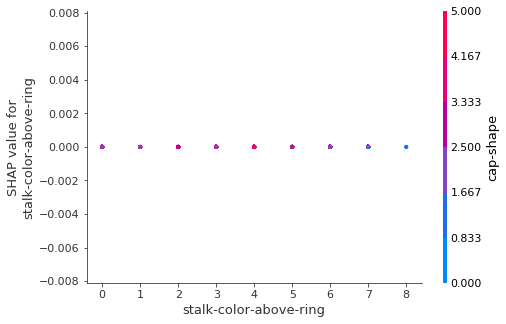

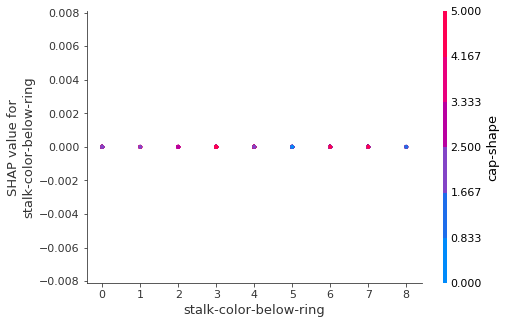

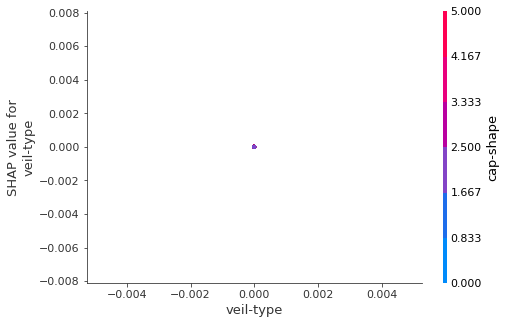

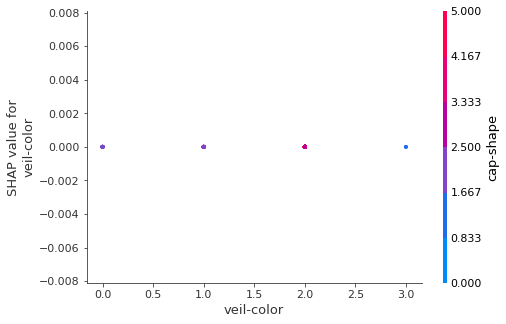

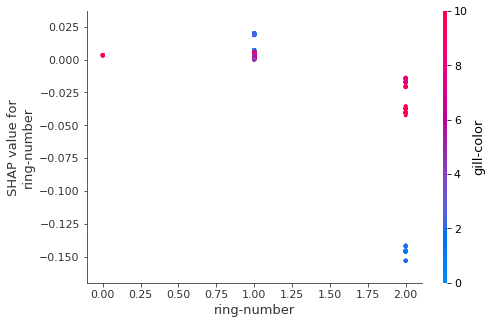

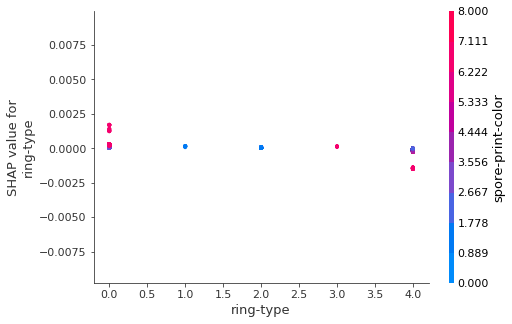

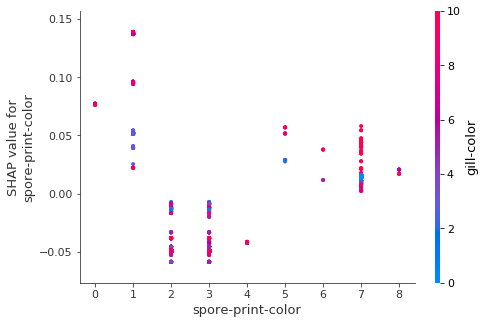

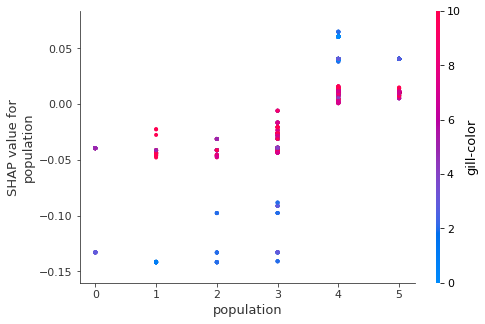

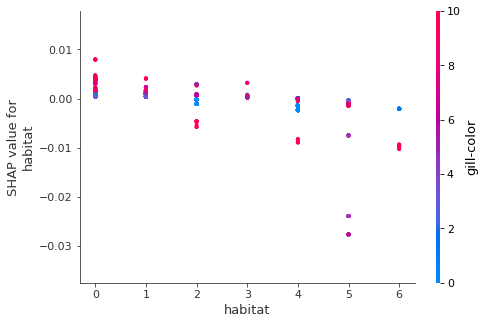

In [43]:
shap.initjs()
for name in x_test.columns:
    shap.dependence_plot(name, shap_values, x_test, display_features=x_test)

# Klasyfikator nieoparty na drzewach 

### próbka o indeksie=2

In [44]:
from sklearn.linear_model import LogisticRegression
acc, model_logistic=classifier(SVC(probability=True)) 
print(acc)

explainer, shap_values=shap_decomposition(model_logistic, False, example_index)
shap.initjs()

display(shap.force_plot(explainer.expected_value[1], shap_values[1], example_sample))

shap_extreme(shap_values, True)

98.8923076923077


l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!


top shap values
gill-color                0.236722
gill-size                 0.136312
spore-print-color         0.091300
cap-surface               0.028186
population                0.026215

smallest shap values
veil-color               0.000000
ring-number              0.000000
ring-type                0.000000
cap-shape                0.000000
bruises                 -0.022543

### próbka o indeksie=119

In [45]:
explainer, shap_values=shap_decomposition(model_logistic, False, 119)
shap.initjs()

display(shap.force_plot(explainer.expected_value[1], shap_values[1], x_test.iloc[119,:]))

shap_extreme(shap_values, True)

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!


top shap values
stalk-shape          0.035646
ring-type            0.026911
habitat              0.021614
gill-spacing         0.009586
ring-number          0.000000

smallest shap values
stalk-root             -0.054729
odor                   -0.061657
gill-size              -0.075460
population             -0.076828
cap-color              -0.083439

Gdy przeanalizowano wartości SHAP dla obserwacji nr 119 gdy zastosowano model light_gbm to jako najważniejsze uznano zmienne:
- odor	
- stalk-root	
- spore-print-color	

Gdy zastosowano model SVM dla tej samej obserwacji, okazało się, że największą kontrybucję miały:
- cap-color 
- gill-size 
- population 

Na czwartym miejscu znalazła się zmienna odor, która tym razem miała kontrybucję o wartości -0.062 (a więc dwa razy mniejszą niż w przypadku klasyfikatora lightgbm)

# Podsumowanie

Narzędzie shap pozwala na tworzenie ciekawych analiz.Analiza dekompozycji dla tej samej zmiennej jednak gdy użyto inne klasyfikatory (choć o bardzo podobnym accuracy) ujawniła odmienne kontrybucje zmiennych, jednak zawsze wśród trzech najważniejszych zmiennych znajdowała się gill-size lub odor. Jednak pozostałe dwie najważniejsze zmienne się różniły i udało się zademostrować taki przykład. Zaobserwowano, że ta sama zmienna w zależności od analizowanej obserwacji może zwiększać bądź zmniejszać predykcję. 